In [2]:
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import cv2
import shutil
from shutil import copyfile
import path

In [3]:
import os
data_folder = "/kaggle/input/brain-tumor-object-detection-datasets"
output_folder = 'braintumors'
data_folder_yolo = output_folder + "_yolo"
data_folder_coco = output_folder + "_coco"
folders = os.listdir(data_folder)
print(folders)

['coronal_t1wce_2_class', 'axial_t1wce_2_class', 'sagittal_t1wce_2_class']


In [4]:
from glob import glob
def count_yolo_data(folder):
    for images_labels in ['images', 'labels']:
        for train_test in ['train', 'test']:
            file_ext = '*.jpg' if images_labels == 'images' else '*.txt'
            p = os.path.join(folder, images_labels, train_test, file_ext)
            files = glob(p)
            print(train_test, images_labels, len(files))

In [5]:
for folder in folders:
    print('-'*8 + folder + '-'*8)
    folder = os.path.join(data_folder, folder)
    count_yolo_data(folder)

--------coronal_t1wce_2_class--------
train images 319
test images 78
train labels 318
test labels 78
--------axial_t1wce_2_class--------
train images 310
test images 75
train labels 296
test labels 75
--------sagittal_t1wce_2_class--------
train images 264
test images 70
train labels 264
test labels 70


In [6]:
import os
import shutil
from tqdm import tqdm
# move all into one folder
def copy_yolo_files(from_folder, to_folder, images_labels, train_test):
    from_path = os.path.join(from_folder, images_labels, train_test)
    to_path = os.path.join(to_folder, images_labels, train_test)
    os.makedirs(to_path, exist_ok = True)
    # get files
    file_ext = "*.jpg" if images_labels == "images" else "*.txt"
    files = glob(os.path.join(from_path, file_ext))
    # move files
    for file in tqdm(files):
        shutil.copy(file, to_path)

In [7]:
# copy
for from_folder in folders:
    from_folder = os.path.join(data_folder, from_folder)
    to_folder = data_folder_yolo
    for images_labels in ['images', 'labels']:
        for train_test in ['train', 'test']:
            copy_yolo_files(from_folder, to_folder, images_labels, train_test)
            

100%|██████████| 70/70 [00:00<00:00, 306.66it/s]


In [8]:
!tree -d {data_folder_yolo}

braintumors_yolo
|-- images
|   |-- test
|   `-- train
`-- labels
    |-- test
    `-- train

6 directories


In [9]:
# read the yaml file and write the class file
import yaml
from yaml.loader import SafeLoader

# Open the file and load the file
with open(os.path.join(data_folder, folders[0], folders[0]+'.yaml')) as f:
      classes = yaml.load(f, Loader=SafeLoader)["names"]
# Write classes.txt
with open(os.path.join(data_folder_yolo, "classes.txt"), "w") as f:
      f.write('\n'.join(classes))

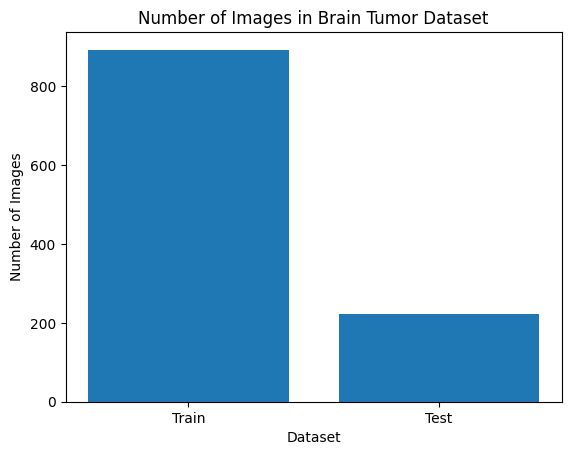

In [42]:
train_data_dir = os.path.join('/kaggle/working', 'braintumors_coco', 'train')
test_data_dir = os.path.join('/kaggle/working', 'braintumors_coco', 'test')

# Get a list of all the image files in the training and test data directories.
train_image_files = glob(os.path.join(train_data_dir, '*.jpg'))
test_image_files = glob(os.path.join(test_data_dir, '*.jpg'))

# Count the number of image files in the training and test data directories.
num_train_images = len(train_image_files)
num_test_images = len(test_image_files)

# Plot the number of training and test images.
plt.bar(['Train', 'Test'], [num_train_images, num_test_images])
plt.title('Number of Images in Brain Tumor Dataset')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.show()

In [10]:
!pip install -q pylabel

In [11]:
from pylabel import importer
def yolo_to_coco(input_folder, output_folder, train_test):
    labels_path = os.path.join(input_folder, "labels", train_test)
    images_path = os.path.join(input_folder, "images", train_test)
    coco_dir = os.path.join(output_folder, train_test)
    os.makedirs(coco_dir, exist_ok=True)
    
    txt_files = glob(os.path.join(labels_path, "*.txt"))
    img_files = glob(os.path.join(images_path, "*.jpg"))
    # copy annotations
    for f in tqdm(txt_files):
        shutil.copy(f, coco_dir)
    # copy images
    for f in tqdm(img_files):
        shutil.copy(f, coco_dir)
    # get the classes
    with open(os.path.join(input_folder, "classes.txt"), "r") as f:
        classes = f.read().split("\n")
    
    # load dataset
    dataset = importer.ImportYoloV5(path=coco_dir, cat_names=classes, name= "brain tumors")
    # export
    coco_file = os.path.join(coco_dir, "_annotations.coco.json")
    # Detectron requires starting index from 1
    dataset.export.ExportToCoco(coco_file, cat_id_index=1)
    # now delete yolo annotations in coco set
    for f in txt_files:
        os.remove(f.replace(labels_path, coco_dir))

In [12]:
yolo_to_coco(data_folder_yolo, data_folder_coco, "train")
yolo_to_coco(data_folder_yolo, data_folder_coco, "test")

Importing YOLO files...: 100%|██████████| 1771/1771 [00:00<00:00, 1986.98it/s]
/opt/conda/lib/python3.10/site-packages/pylabel/exporter.py:767: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(r"^\s*$", np.nan, regex=True)
Importing YOLO files...: 100%|██████████| 446/446 [00:00<00:00, 1959.98it/s]
/opt/conda/lib/python3.10/site-packages/pylabel/exporter.py:767: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(r"^\s*$", np.nan, regex=True)
Exporting to COCO file...: 100%|██████████| 241/241 [00:00<00:00, 

In [13]:
!tree -d {data_folder_coco}

braintumors_coco
|-- test
`-- train

2 directories


In [14]:
!python -m pip install \
'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-7vtr_v9k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-7vtr_v9k
  Resolved https://github.com/facebookresearch/detectron2.git to commit eb96ee1d4752ff5896f623f738641fba9c755237
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.

In [15]:
import torch
from detectron2.utils.logger import setup_logger
logger = setup_logger()
from detectron2.data.datasets import register_coco_instances

In [18]:
# Some configurations
name_ds = "braintumors_coco"
name_ds_train = name_ds + "_train"
name_ds_test = name_ds + "_test"
image_root_train = name_ds + "/train"
image_root_test = name_ds + "/test"
af = "_annotations.coco.json"
json_file_train = name_ds + "/train/" + af
json_file_test = name_ds + "/test/" + af

In [19]:
# Register datasets
## train dataset
register_coco_instances(
    name = name_ds_train,
    metadata = {},
    json_file = json_file_train,
    image_root = image_root_train
    )
## test dataset
register_coco_instances(
    name = name_ds_test,
    metadata = {},
    json_file = json_file_test,
    image_root = image_root_test
    )

In [32]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import random
random.seed(42)
import cv2
import matplotlib.pyplot as plt

def plot_random_samples(name_ds, n=3):
    # access
    ds = DatasetCatalog.get(name_ds)
    met = MetadataCatalog.get(name_ds)
    # plot (arrange in 3x3)
    nrows = int(-(-n/3)) # ceil
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
    for i,s in enumerate(random.sample(ds, n)):
        ax = axs[i//ncols][i%ncols] if len(axs.shape) == 2 else axs[i]
        img = cv2.imread(s["file_name"])
        v = Visualizer(img[:,:, ::-1], metadata=met, scale=0.5)
        v = v.draw_dataset_dict(s)
        ax.imshow(v.get_image())
        ax.set_title(f"Image: {s['file_name']}, "
                     f"\nHeight: {s['height']}, "
                     f"\nWidth: {s['width']}, "
                     f"\nAnnotations: {len(s['annotations'])}")
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()

[03/28 04:47:44 d2.data.datasets.coco]: Loaded 878 images in COCO format from braintumors_coco/train/_annotations.coco.json


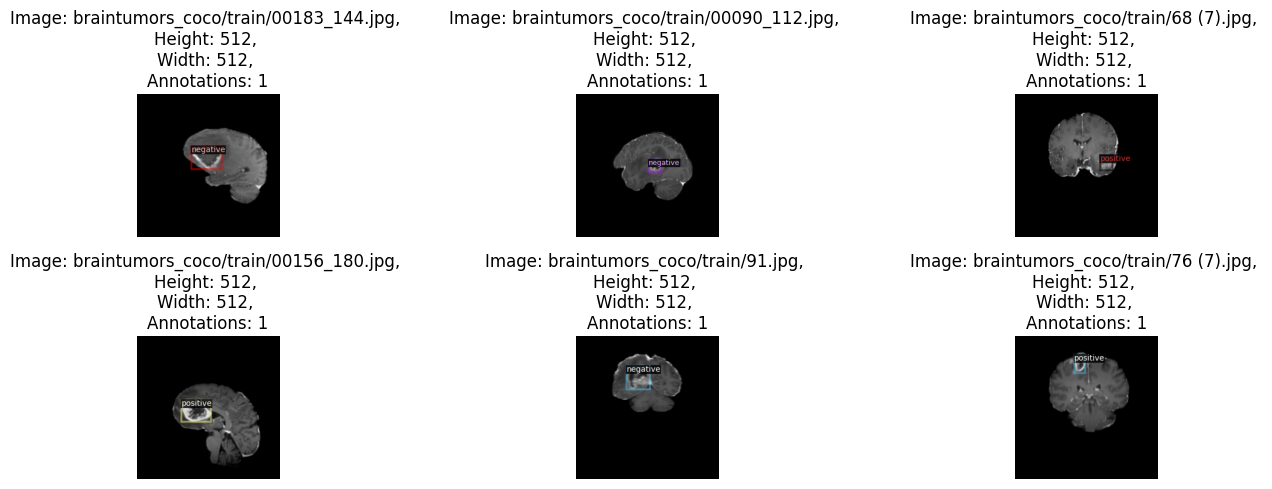

In [33]:
plot_random_samples(name_ds_train, n=6)